# Model Training

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_addons as tfa

from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam

### Read Processed Data

In [149]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv').dropna()
print('Number of listings: ' + str(len(listings_df)))

Number of listings: 126754


In [150]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,age,yard_area,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Capitale-Nationale,2020,16,2885,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Mauricie,2021,64,8239,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Lachine,2021,15,0,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Capitale-Nationale,2021,2,14976,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Outaouais,2021,32,2071,2021-12-01,1989,360000


### Choosing columnns

In [151]:
ordinal_cols = []
one_hot_cols = ['location', 'subtype']
numerical_cols = ['living_area', 'bedrooms', 'bathrooms', 'levels', 'age', 'listing_year']
target_col = ['price']

In [152]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]
listings_df.head()

,location,subtype,living_area,bedrooms,bathrooms,levels,age,listing_year,price
0,Capitale-Nationale,2 Storey,1191,3,1,2,16,2020,332500
1,Mauricie,Bungalow,1261,2,1,1,64,2021,265000
2,Lachine,Townhouse,1645,3,1,3,15,2021,612000
3,Capitale-Nationale,Bi-generation,2024,4,3,1,2,2021,526500
4,Outaouais,Semi-detached,2400,4,2,2,32,2021,360000


### One Hot Encoding

In [153]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [154]:
listings_df.head()

,living_area,bedrooms,bathrooms,levels,age,listing_year,price,Capitale-Nationale_location,Mauricie_location,Lachine_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
0,1191,3,1,2,16,2020,332500,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1261,2,1,1,64,2021,265000,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1645,3,1,3,15,2021,612000,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,2024,4,3,1,2,2021,526500,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2400,4,2,2,32,2021,360000,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Ordinal Encoding

In [155]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    ordinal_encoders[col].fit(listings_df[[col]])
    listings_df[col] = ordinal_encoders[col].transform(listings_df[[col]])

listings_df.head()

,living_area,bedrooms,bathrooms,levels,age,listing_year,price,Capitale-Nationale_location,Mauricie_location,Lachine_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
0,1191,3,1,2,16,2020,332500,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1261,2,1,1,64,2021,265000,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1645,3,1,3,15,2021,612000,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,2024,4,3,1,2,2021,526500,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2400,4,2,2,32,2021,360000,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Split Data (Test/Train)

In [156]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Scale Data
Using Min Max Scaler

In [157]:
scaled_cols = numerical_cols + ordinal_cols

scalers = {}

for col in scaled_cols:
    scalers[col] = MinMaxScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [158]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

X_train.head()

,living_area,bedrooms,bathrooms,levels,age,listing_year,Capitale-Nationale_location,Mauricie_location,Lachine_location,Outaouais_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
85044,0.235608,0.8,0.333333,0.5,0.015823,1.000000,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
91567,0.170482,0.6,0.333333,0.0,0.145570,1.000000,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
51094,0.201823,0.6,0.333333,0.0,0.009494,0.555556,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
97291,0.102245,0.4,0.333333,0.0,0.098101,1.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
70375,0.130696,0.4,0.000000,0.0,0.050633,0.166667,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Neural Network Training

In [159]:
model = Sequential()
model.add(Dense(units=50, activation='tanh', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=25, activation='tanh'))
model.add(Dense(units=5, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

print(model.summary())

model.compile(optimizer=Adam(lr=0.001), loss='mse')

history = model.fit(X_train, y_train, batch_size=1000, epochs=200, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 50)                2600      
                                                                 
 dense_63 (Dense)            (None, 25)                1275      
                                                                 
 dense_64 (Dense)            (None, 5)                 130       
                                                                 
 dense_65 (Dense)            (None, 1)                 6         
                                                                 
Total params: 4,011
Trainable params: 4,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200


c:\Users\simka\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


102/102 [==============================] - 1s 3ms/step - loss: 0.0304 - val_loss: 0.0078
Epoch 2/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 3/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 4/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 5/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 6/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 7/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 8/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 9/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 10/200
102/102 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0052
E

In [160]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

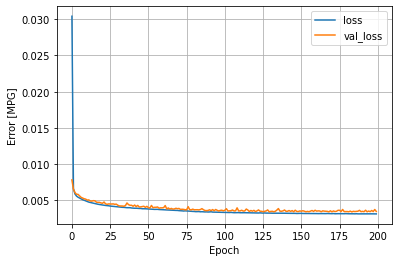

In [161]:
plot_loss(history)

In [168]:
predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [169]:
test_df = X_test.copy()

for col in scaled_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

In [170]:
d = {}
d['real price'] = list(real_prices)
d['predicted price'] = list(predicted_prices)

test_df['real price'] = d['real price']
test_df['predicted price'] = d['predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['predicted price'] = test_df['predicted price'].astype(int)

In [171]:
test_df.head(12)

,living_area,bedrooms,bathrooms,levels,age,listing_year,Capitale-Nationale_location,Mauricie_location,Lachine_location,Outaouais_location,...,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype,real price,predicted price
99425,1560.0,5.0,2.0,2.0,5.0,2021.0,1,0,0,0,...,0,0,0,1,0,0,0,0,610000,612734
48880,1321.0,3.0,2.0,1.0,40.0,2014.0,0,0,0,1,...,1,0,0,0,0,0,0,0,281500,272485
123044,1350.0,3.0,1.0,2.0,5.0,2012.0,0,0,0,0,...,0,0,0,0,0,0,0,1,251000,268670
4210,1281.0,3.0,2.0,1.0,53.0,2021.0,0,0,0,0,...,1,0,0,0,0,0,0,0,325000,428333
84913,960.0,3.0,2.0,1.0,31.0,2021.0,0,0,0,0,...,1,0,0,0,0,0,0,0,400000,407812
23963,1029.0,3.0,2.0,1.0,51.0,2018.0,1,0,0,0,...,1,0,0,0,0,0,0,0,270000,280275
56735,1120.0,4.0,1.0,1.0,9.0,2012.0,0,0,0,0,...,1,0,0,0,0,0,0,0,284000,282527
114491,861.0,3.0,2.0,2.0,26.0,2019.0,0,0,1,0,...,0,0,0,0,0,0,0,1,329000,320332
94750,2024.0,4.0,3.0,1.0,2.0,2021.0,1,0,0,0,...,0,0,1,0,0,0,0,0,526500,531884
16073,1200.0,3.0,1.0,2.0,83.0,2020.0,0,0,0,1,...,0,0,0,0,0,0,0,0,157000,246633


In [172]:
errors = abs(predicted_prices - real_prices)
errors_small = list(filter(lambda x: x < 100000, errors))
errors_pct = 100 * (abs(predicted_prices - real_prices) / real_prices)
errors_pct_small = list(filter(lambda x: x < 100, errors_pct))

In [173]:
e_avg = int(np.mean(errors))
e_std = int(np.std(errors))
epct_avg = round(np.mean(errors_pct), 2)
epct_std = round(np.std(errors_pct), 2)

print('Error Mean ($): ' + str(e_avg) + '$')
print('Error std ($): ' + str(e_std) + '$')
print('Error Mean (%): ' + str(epct_avg) + '%')
print('Error std (%): ' + str(epct_std) + '%')

Error Mean ($): 35814$
Error std ($): 44189$
Error Mean (%): 14.16%
Error std (%): 20.21%
